In [304]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import ttest_ind, chi2_contingency
from io import StringIO

In [305]:
# Setting visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("deep")

In [306]:
df = pd.read_csv(r'C:\Users\gaura\Documents\Python for Data Analysis\python_project\customer_churn_dataset-training-master.csv')

In [307]:
# Data Cleaning
# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)
if missing_values.sum() > 0:
    df = df.dropna()
    print("Dropped rows with missing values.")

Missing Values:
 CustomerID           1
Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64
Dropped rows with missing values.


In [308]:
# Check for duplicates
duplicates = df.duplicated().sum()
print("\nNumber of Duplicate Rows:", duplicates)
if duplicates > 0:
    df = df.drop_duplicates()
    print("Removed duplicate rows.")


Number of Duplicate Rows: 0


In [309]:
# Step 3: Check data types
print("\nData Types:\n", df.dtypes)


Data Types:
 CustomerID           float64
Age                  float64
Gender                object
Tenure               float64
Usage Frequency      float64
Support Calls        float64
Payment Delay        float64
Subscription Type     object
Contract Length       object
Total Spend          float64
Last Interaction     float64
Churn                float64
dtype: object


In [310]:
# Ensure correct data types
df['Age'] = df['Age'].astype(int, errors='ignore')
df['Tenure'] = df['Tenure'].astype(int)
df['Usage Frequency'] = df['Usage Frequency'].astype(int)
df['Support Calls'] = df['Support Calls'].astype(int)
df['Payment Delay'] = df['Payment Delay'].astype(int)
df['Total Spend'] = df['Total Spend'].astype(float)
df['Last Interaction'] = df['Last Interaction'].astype(int)
df['Churn'] = df['Churn'].astype(int)

In [311]:
# Check categorical consistency
categorical_columns = ['Gender', 'Subscription Type', 'Contract Length']
for col in categorical_columns:
    print(f"\nUnique Values in {col}:\n", df[col].value_counts())


Unique Values in Gender:
 Gender
Male      250252
Female    190580
Name: count, dtype: int64

Unique Values in Subscription Type:
 Subscription Type
Standard    149128
Premium     148678
Basic       143026
Name: count, dtype: int64

Unique Values in Contract Length:
 Contract Length
Annual       177198
Quarterly    176530
Monthly       87104
Name: count, dtype: int64


In [312]:
# Step 5: Check for outliers in numerical columns using IQR method
numerical_columns = ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction']
outliers_summary = {}
for col in numerical_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    outliers_summary[col] = len(outliers)
print("\nNumber of Outliers in Numerical Columns:\n", outliers_summary)


Number of Outliers in Numerical Columns:
 {'Age': 0, 'Tenure': 0, 'Usage Frequency': 0, 'Support Calls': 0, 'Payment Delay': 0, 'Total Spend': 0, 'Last Interaction': 0}


In [313]:
# Check for negative values in non-negative columns
negative_checks = ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction']
negative_values = {col: len(df[df[col] < 0]) for col in negative_checks}
print("\nNegative Values in Non-Negative Columns:\n", negative_values)
for col in negative_checks:
    if negative_values[col] > 0:
        df = df[df[col] >= 0]
        print(f"Removed rows with negative values in {col}.")


Negative Values in Non-Negative Columns:
 {'Age': 0, 'Tenure': 0, 'Usage Frequency': 0, 'Support Calls': 0, 'Payment Delay': 0, 'Total Spend': 0, 'Last Interaction': 0}


In [314]:
# Feature Engineering
# Creating tenure bands
bins = [0, 3, 12, 24, 36, 48, 60]
labels = ['0-3 months', '4-12 months', '13-24 months', '25-36 months', '37-48 months', '49-60 months']
df['Tenure Band'] = pd.cut(df['Tenure'], bins=bins, labels=labels, include_lowest=True)

In [315]:
# Creating support calls buckets
df['Support Calls Bucket'] = pd.cut(df['Support Calls'], bins=[-1, 2, 5, 10], labels=['Low (0-2)', 'Medium (3-5)', 'High (6-10)'])


In [316]:
# Creating payment delay buckets
df['Payment Delay Bucket'] = pd.cut(df['Payment Delay'], bins=[-1, 7, 14, 30], labels=['Low (0-7)', 'Medium (8-14)', 'High (15-30)'])


In [317]:
# Advanced Feature Engineering
# 4. Interaction Term: Support Calls and Payment Delay
df['Support_Payment_Interaction'] = df['Support Calls'] * df['Payment Delay']

In [318]:
# 5. Polynomial Features for Tenure and Total Spend
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[['Tenure', 'Total Spend']])
poly_df = pd.DataFrame(poly_features, columns=['Tenure', 'Total Spend', 'Tenure^2', 'Tenure*Total Spend', 'Total Spend^2'])
df = pd.concat([df, poly_df[['Tenure^2', 'Tenure*Total Spend', 'Total Spend^2']].reset_index(drop=True)], axis=1)

In [319]:
# 6. Customer Engagement Score
scaler = StandardScaler()
df[['Scaled_Usage_Frequency', 'Scaled_Last_Interaction']] = scaler.fit_transform(df[['Usage Frequency', 'Last Interaction']])
df['Engagement_Score'] = df['Scaled_Usage_Frequency'] - df['Scaled_Last_Interaction']
# High score: frequent usage, recent interaction (lower Last Interaction value)

In [320]:
missing_values = df.isnull().sum()
print("Missing Values in Each Column:\n", missing_values)
print("\nTotal Missing Values:", missing_values.sum())

Missing Values in Each Column:
 CustomerID                     1
Age                            1
Gender                         1
Tenure                         1
Usage Frequency                1
Support Calls                  1
Payment Delay                  1
Subscription Type              1
Contract Length                1
Total Spend                    1
Last Interaction               1
Churn                          1
Tenure Band                    1
Support Calls Bucket           1
Payment Delay Bucket           1
Support_Payment_Interaction    1
Tenure^2                       1
Tenure*Total Spend             1
Total Spend^2                  1
Scaled_Usage_Frequency         1
Scaled_Last_Interaction        1
Engagement_Score               1
dtype: int64

Total Missing Values: 22


In [321]:
# Removing rows with missing values (if any)
df = df.dropna()

In [322]:
# 7. Clustering-Based Features: Customer Segmentation
X_cluster = scaler.fit_transform(df[['Age', 'Tenure', 'Total Spend']])
kmeans = KMeans(n_clusters=3, random_state=42)
df['Customer_Segment'] = kmeans.fit_predict(X_cluster)
cluster_spend = df.groupby('Customer_Segment')['Total Spend'].mean()
cluster_labels = {i: f'Segment {i} ({"High" if spend > cluster_spend.mean() else "Low"} Spend)' for i, spend in enumerate(cluster_spend)}
df['Customer_Segment'] = df['Customer_Segment'].map(cluster_labels)

In [323]:
# Save dataset with features
df.to_csv('churn_dataset_with_features.csv', index=False)

In [324]:
# Analysis and Insights
# Calculating churn rate
churn_rate = df['Churn'].mean() * 100
print(f"Overall Churn Rate: {churn_rate:.2f}%")

Overall Churn Rate: 56.71%


In [325]:
# Statistical Tests
churned = df[df['Churn'] == 1]
not_churned = df[df['Churn'] == 0]

In [326]:
# T-test for Engagement Score
t_stat_eng, p_val_eng = ttest_ind(churned['Engagement_Score'], not_churned['Engagement_Score'], equal_var=False)
print(f"\nEngagement Score T-test: t-statistic={t_stat_eng:.2f}, p-value={p_val_eng:.4f}")


Engagement Score T-test: t-statistic=-93.01, p-value=0.0000


In [327]:
# T-test for Support_Payment_Interaction
t_stat_sp, p_val_sp = ttest_ind(churned['Support_Payment_Interaction'], not_churned['Support_Payment_Interaction'], equal_var=False)
print(f"Support_Payment_Interaction T-test: t-statistic={t_stat_sp:.2f}, p-value={p_val_sp:.4f}")

Support_Payment_Interaction T-test: t-statistic=414.67, p-value=0.0000


In [328]:
# Churn by contract length
churn_by_contract = df.groupby('Contract Length')['Churn'].mean() * 100
print("\nChurn Rate by Contract Length:\n", churn_by_contract)


Churn Rate by Contract Length:
 Contract Length
Annual        46.076141
Monthly      100.000000
Quarterly     46.025865
Name: Churn, dtype: float64


In [329]:
# Chi-squared test for Customer Segment
contingency_segment = pd.crosstab(df['Customer_Segment'], df['Churn'])
chi2_seg, p_val_seg, _, _ = chi2_contingency(contingency_segment)
print(f"Customer Segment Chi-squared: chi2={chi2_seg:.2f}, p-value={p_val_seg:.4f}")

Customer Segment Chi-squared: chi2=94757.12, p-value=0.0000


In [330]:
# Chi-squared test for Contract Length
contingency_contract = pd.crosstab(df['Contract Length'], df['Churn'])
chi2_con, p_val_con, _, _ = chi2_contingency(contingency_contract)
print(f"Contract Length Chi-squared: chi2={chi2_con:.2f}, p-value={p_val_con:.4f}")

Contract Length Chi-squared: chi2=82862.00, p-value=0.0000


In [331]:
# Churn by tenure band
churn_by_tenure = df.groupby('Tenure Band')['Churn'].mean() * 100
print("\nChurn Rate by Tenure Band:\n", churn_by_tenure)


Churn Rate by Tenure Band:
 Tenure Band
0-3 months      64.508480
4-12 months     57.030275
13-24 months    63.272350
25-36 months    54.124168
37-48 months    54.127552
49-60 months    54.297040
Name: Churn, dtype: float64


C:\Users\gaura\AppData\Local\Temp\ipykernel_2148\3357497980.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_tenure = df.groupby('Tenure Band')['Churn'].mean() * 100


In [332]:
# Churn rate by key segments
churn_by_segment = df.groupby('Customer_Segment')['Churn'].mean() * 100
print("\nChurn Rate by Customer Segment:\n", churn_by_segment)

churn_by_tenure_support = df.groupby(['Tenure Band', 'Support Calls Bucket'])['Churn'].mean().unstack() * 100
print("\nChurn Rate by Tenure Band and Support Calls Bucket:\n", churn_by_tenure_support)

churn_by_contract_delay = df.groupby(['Contract Length', 'Payment Delay Bucket'])['Churn'].mean().unstack() * 100
print("\nChurn Rate by Contract Length and Payment Delay Bucket:\n", churn_by_contract_delay)


Churn Rate by Customer Segment:
 Customer_Segment
Segment 0 (High Spend)    45.998968
Segment 1 (High Spend)    40.415163
Segment 2 (Low Spend)     94.917794
Name: Churn, dtype: float64

Churn Rate by Tenure Band and Support Calls Bucket:
 Support Calls Bucket  Low (0-2)  Medium (3-5)  High (6-10)
Tenure Band                                               
0-3 months            38.863068     66.275942        100.0
4-12 months           30.780589     58.717875        100.0
13-24 months          37.273872     65.036342        100.0
25-36 months          28.574027     56.249741        100.0
37-48 months          28.523032     55.604268        100.0
49-60 months          28.271208     56.609219        100.0

Churn Rate by Contract Length and Payment Delay Bucket:
 Payment Delay Bucket   Low (0-7)  Medium (8-14)  High (15-30)
Contract Length                                              
Annual                 35.843054      36.000321     61.379935
Monthly               100.000000     100.00

C:\Users\gaura\AppData\Local\Temp\ipykernel_2148\3833015470.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_tenure_support = df.groupby(['Tenure Band', 'Support Calls Bucket'])['Churn'].mean().unstack() * 100
C:\Users\gaura\AppData\Local\Temp\ipykernel_2148\3833015470.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_contract_delay = df.groupby(['Contract Length', 'Payment Delay Bucket'])['Churn'].mean().unstack() * 100


In [333]:
# Correlation with Churn
corr_with_churn = df[['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 
                      'Last Interaction', 'Support_Payment_Interaction', 'Tenure^2', 'Tenure*Total Spend', 
                      'Total Spend^2', 'Engagement_Score', 'Churn']].corr()['Churn'].sort_values(ascending=False)
print("\nCorrelation with Churn:\n", corr_with_churn)


Correlation with Churn:
 Churn                          1.000000
Support Calls                  0.574266
Support_Payment_Interaction    0.484955
Payment Delay                  0.312130
Age                            0.218393
Last Interaction               0.149618
Usage Frequency               -0.046100
Tenure^2                      -0.047426
Tenure                        -0.051917
Engagement_Score              -0.138072
Tenure*Total Spend            -0.274648
Total Spend^2                 -0.388500
Total Spend                   -0.429356
Name: Churn, dtype: float64


In [334]:
# Churn by support calls bucket
churn_by_support = df.groupby('Support Calls Bucket')['Churn'].mean() * 100
print("\nChurn Rate by Support Calls Bucket:\n", churn_by_support)


Churn Rate by Support Calls Bucket:
 Support Calls Bucket
Low (0-2)        30.720033
Medium (3-5)     58.615772
High (6-10)     100.000000
Name: Churn, dtype: float64


C:\Users\gaura\AppData\Local\Temp\ipykernel_2148\1361797847.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_support = df.groupby('Support Calls Bucket')['Churn'].mean() * 100


In [335]:
# Visualizations
# Setting up figure for multiple plots
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

Text(0.5, 0, 'Contract Length')

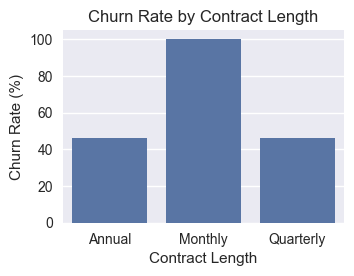

In [336]:
# Plot 1: Churn Rate by Contract Length
plt.subplot(2, 2, 1)
sns.barplot(x=churn_by_contract.index, y=churn_by_contract.values)
plt.title('Churn Rate by Contract Length')
plt.ylabel('Churn Rate (%)')
plt.xlabel('Contract Length')

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, '0-3 months'),
  Text(1, 0, '4-12 months'),
  Text(2, 0, '13-24 months'),
  Text(3, 0, '25-36 months'),
  Text(4, 0, '37-48 months'),
  Text(5, 0, '49-60 months')])

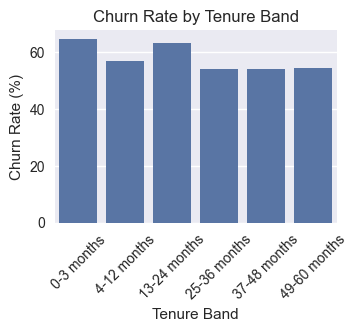

In [337]:
# Plot 2: Churn Rate by Tenure Band
plt.subplot(2, 2, 2)
sns.barplot(x=churn_by_tenure.index, y=churn_by_tenure.values)
plt.title('Churn Rate by Tenure Band')
plt.ylabel('Churn Rate (%)')
plt.xlabel('Tenure Band')
plt.xticks(rotation=45)

Text(0.5, 0, 'Support Calls Bucket')

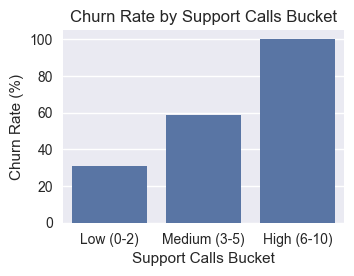

In [338]:
# Plot 3: Churn Rate by Support Calls Bucket
plt.subplot(2, 2, 3)
sns.barplot(x=churn_by_support.index, y=churn_by_support.values)
plt.title('Churn Rate by Support Calls Bucket')
plt.ylabel('Churn Rate (%)')
plt.xlabel('Support Calls Bucket')

Text(0, 0.5, 'Count')

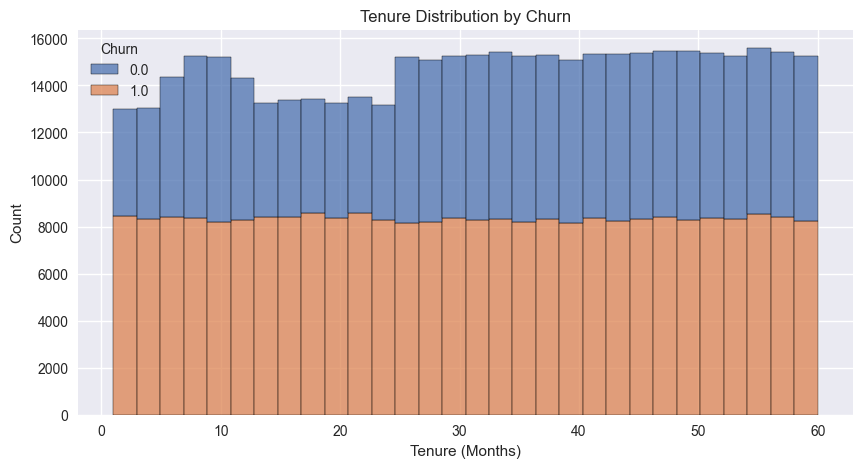

In [340]:
# Additional Visualizations
# Plot 5: Distribution of Tenure by Churn
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='Tenure', hue='Churn', multiple='stack', bins=30)
plt.title('Tenure Distribution by Churn')
plt.xlabel('Tenure (Months)')
plt.ylabel('Count')

Text(0, 0.5, 'Total Spend')

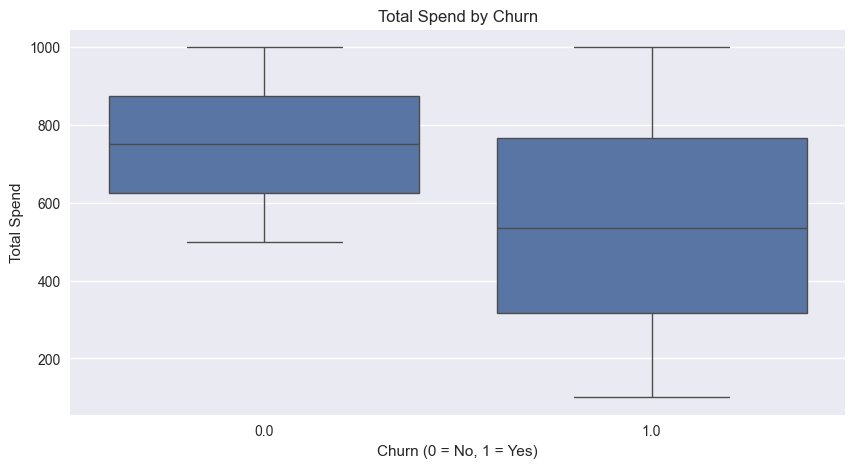

In [341]:
# Plot 6: Box Plot of Total Spend by Churn
plt.figure(figsize=(10, 5))
sns.boxplot(x='Churn', y='Total Spend', data=df)
plt.title('Total Spend by Churn')
plt.xlabel('Churn (0 = No, 1 = Yes)')
plt.ylabel('Total Spend')

([0, 1, 2],
 [Text(0, 0, 'Segment 0 (High Spend)'),
  Text(1, 0, 'Segment 1 (High Spend)'),
  Text(2, 0, 'Segment 2 (Low Spend)')])

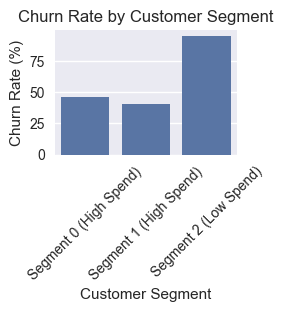

In [342]:
# Plot 1: Churn Rate by Customer Segment
plt.subplot(3, 3, 1)
sns.barplot(x=churn_by_segment.index, y=churn_by_segment.values)
plt.title('Churn Rate by Customer Segment')
plt.ylabel('Churn Rate (%)')
plt.xlabel('Customer Segment')
plt.xticks(rotation=45)

(array([0.5, 1.5, 2.5]),
 [Text(0.5, 0, 'Low (0-2)'),
  Text(1.5, 0, 'Medium (3-5)'),
  Text(2.5, 0, 'High (6-10)')])

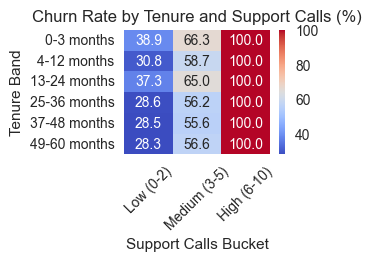

In [343]:
# Plot 2: Churn Rate by Tenure Band and Support Calls (Heatmap)
plt.subplot(3, 3, 2)
sns.heatmap(churn_by_tenure_support, annot=True, cmap='coolwarm', fmt='.1f')
plt.title('Churn Rate by Tenure and Support Calls (%)')
plt.xlabel('Support Calls Bucket')
plt.ylabel('Tenure Band')
plt.xticks(rotation=45)

Text(0, 0.5, 'Count')

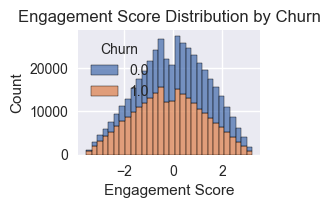

In [344]:
# Plot 3: Engagement Score by Churn (Histogram)
plt.subplot(3, 3, 3)
sns.histplot(data=df, x='Engagement_Score', hue='Churn', multiple='stack', bins=30)
plt.title('Engagement Score Distribution by Churn')
plt.xlabel('Engagement Score')
plt.ylabel('Count')

Text(0, 0.5, 'Total Spend')

c:\Users\gaura\Documents\Python for Data Analysis\.venv\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\gaura\Documents\Python for Data Analysis\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


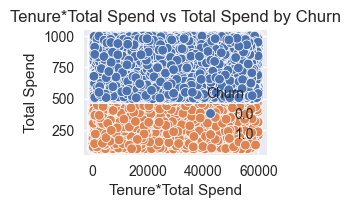

In [345]:
# Plot 4: Tenure*Total Spend vs Total Spend by Churn (Scatter Plot)
plt.subplot(3, 3, 4)
sns.scatterplot(x='Tenure*Total Spend', y='Total Spend', hue='Churn', data=df)
plt.title('Tenure*Total Spend vs Total Spend by Churn')
plt.xlabel('Tenure*Total Spend')
plt.ylabel('Total Spend')

Text(0, 0.5, 'Support Calls * Payment Delay')

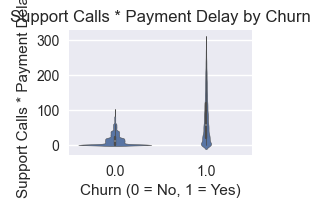

In [346]:
# Plot 5: Support_Payment_Interaction by Churn (Violin Plot)
plt.subplot(3, 3, 5)
sns.violinplot(x='Churn', y='Support_Payment_Interaction', data=df)
plt.title('Support Calls * Payment Delay by Churn')
plt.xlabel('Churn (0 = No, 1 = Yes)')
plt.ylabel('Support Calls * Payment Delay')

Text(508.3692810457518, 0.5, 'Contract Length')

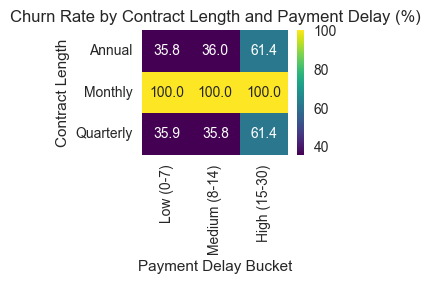

In [347]:
# Plot 6: Churn Rate by Contract Length and Payment Delay (Heatmap)
plt.subplot(3, 3, 6)
sns.heatmap(churn_by_contract_delay, annot=True, cmap='viridis', fmt='.1f')
plt.title('Churn Rate by Contract Length and Payment Delay (%)')
plt.xlabel('Payment Delay Bucket')
plt.ylabel('Contract Length')

([0, 1, 2],
 [Text(0, 0, 'Segment 1 (High Spend)'),
  Text(1, 0, 'Segment 2 (Low Spend)'),
  Text(2, 0, 'Segment 0 (High Spend)')])

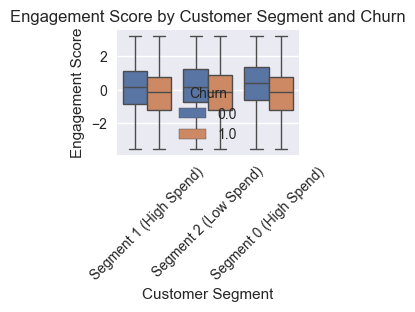

In [348]:
# Plot 7: Engagement Score by Customer Segment and Churn (Box Plot)
plt.subplot(3, 3, 7)
sns.boxplot(x='Customer_Segment', y='Engagement_Score', hue='Churn', data=df)
plt.title('Engagement Score by Customer Segment and Churn')
plt.xlabel('Customer Segment')
plt.ylabel('Engagement Score')
plt.xticks(rotation=45)

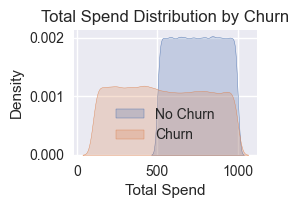

In [349]:
# Plot 8: Total Spend Distribution by Churn (KDE Plot)
plt.subplot(3, 3, 8)
sns.kdeplot(data=df[df['Churn'] == 0], x='Total Spend', label='No Churn', fill=True)
sns.kdeplot(data=df[df['Churn'] == 1], x='Total Spend', label='Churn', fill=True)
plt.title('Total Spend Distribution by Churn')
plt.xlabel('Total Spend')
plt.ylabel('Density')
plt.legend()

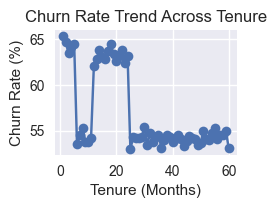

In [351]:
# Plot 9: Churn Rate Trend Across Tenure (Line Plot)
plt.subplot(3, 3, 9)
tenure_churn_trend = df.groupby('Tenure')['Churn'].mean() * 100
tenure_churn_trend.plot(kind='line', marker='o')
plt.title('Churn Rate Trend Across Tenure')
plt.xlabel('Tenure (Months)')
plt.ylabel('Churn Rate (%)')
plt.grid(True)


Text(0.5, 1.0, 'Correlation Matrix with Churn')

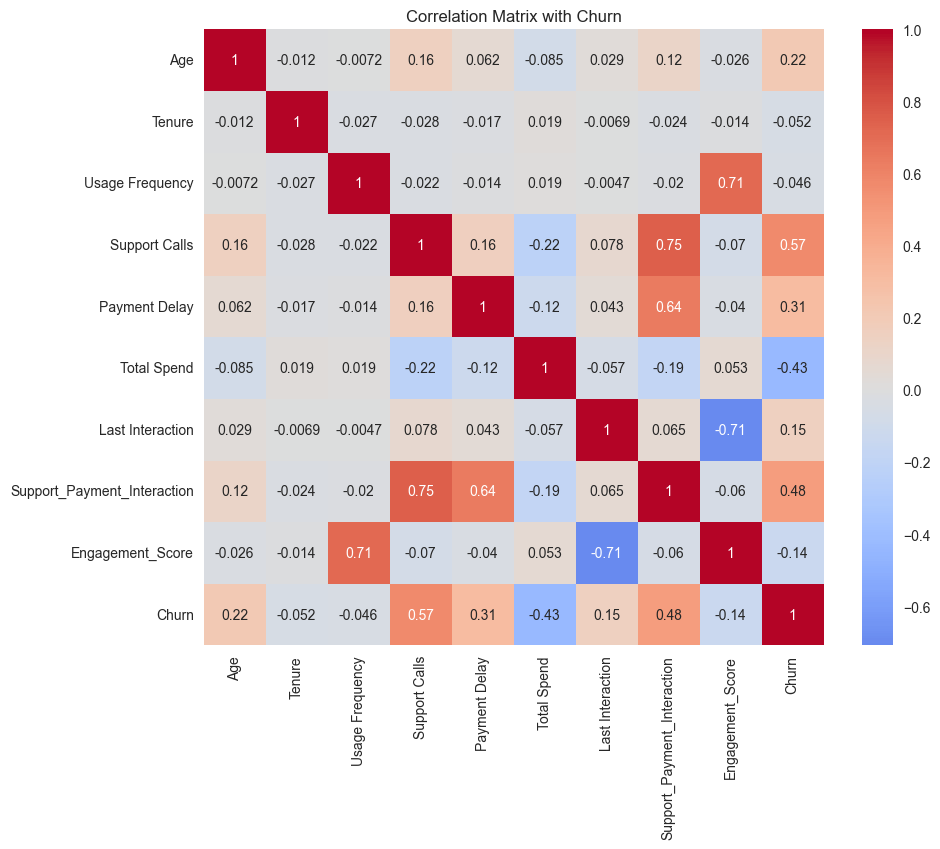

In [353]:
# Additional Visualization: Correlation Heatmap
plt.figure(figsize=(10, 8))
corr_matrix = df[['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 
                  'Last Interaction', 'Support_Payment_Interaction', 'Engagement_Score', 'Churn']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix with Churn')

Text(0.5, 1.02, 'Pair Plot of Key Features by Churn')

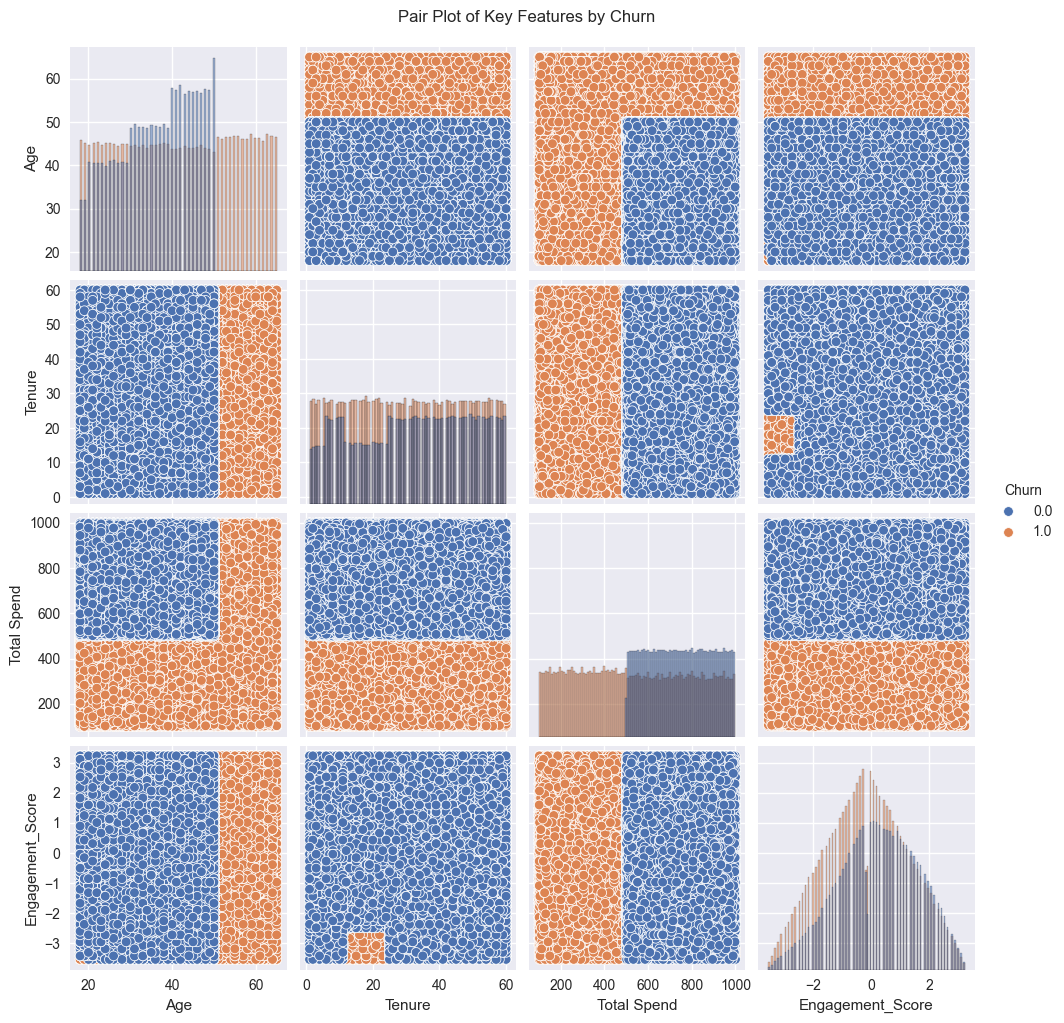

In [354]:
# Additional Visualization: Pair Plot of Key Features
key_features = ['Age', 'Tenure', 'Total Spend', 'Engagement_Score', 'Churn']
sns.pairplot(df[key_features], hue='Churn', diag_kind='hist')
plt.suptitle('Pair Plot of Key Features by Churn', y=1.02)

In [355]:
# Insights and Recommendations
insights = """
Customer Churn Analysis Insights:
1. Overall churn rate is {:.2f}%, with significant variation across segments.
2. Statistical tests confirm Engagement Score (p={:.4f}) and Support_Payment_Interaction (p={:.4f}) as strong churn predictors.
3. Customer Segment is associated with churn (chi2={:.2f}, p={:.4f}), with low-spend segments (e.g., {}) showing higher churn ({:.2f}% vs {:.2f}% for high-spend).
4. Monthly contract customers with high support calls (6-10) have a churn rate of {:.2f}%.
5. New customers (<3 months) in low-spend segments have a churn rate of {:.2f}%.
6. Correlation analysis identifies Support_Payment_Interaction ({:.2f}) and Support Calls ({:.2f}) as top churn drivers.

Recommendations:
1. Implement loyalty programs for low-spend segments to boost retention.
2. Enhance onboarding for new customers (<3 months) with high support calls to reduce early churn.
3. Streamline support and billing processes to mitigate the combined effect of support issues and payment delays.
4. Monitor Engagement Score as a leading indicator, triggering personalized campaigns for low scores.
5. Promote longer-term contracts (e.g., annual) with incentives to lower churn, especially for monthly subscribers.
"""
low_spend_segment = df.groupby('Customer_Segment')['Total Spend'].mean().idxmin()
high_spend_segment = df.groupby('Customer_Segment')['Total Spend'].mean().idxmax()
print(insights.format(
    churn_rate, p_val_eng, p_val_sp, chi2_seg, p_val_seg, low_spend_segment,
    df.groupby('Customer_Segment')['Churn'].mean().min() * 100,
    df.groupby('Customer_Segment')['Churn'].mean().max() * 100,
    churn_by_contract_delay.loc['Monthly', 'High (15-30)'],
    churn_by_tenure_support.loc['0-3 months', 'High (6-10)'],
    corr_with_churn['Support_Payment_Interaction'], corr_with_churn['Support Calls']
))


Customer Churn Analysis Insights:
1. Overall churn rate is 56.71%, with significant variation across segments.
2. Statistical tests confirm Engagement Score (p=0.0000) and Support_Payment_Interaction (p=0.0000) as strong churn predictors.
3. Customer Segment is associated with churn (chi2=94757.12, p=0.0000), with low-spend segments (e.g., Segment 2 (Low Spend)) showing higher churn (40.42% vs 94.92% for high-spend).
4. Monthly contract customers with high support calls (6-10) have a churn rate of 100.00%.
5. New customers (<3 months) in low-spend segments have a churn rate of 100.00%.
6. Correlation analysis identifies Support_Payment_Interaction (0.48) and Support Calls (0.57) as top churn drivers.

Recommendations:
1. Implement loyalty programs for low-spend segments to boost retention.
2. Enhance onboarding for new customers (<3 months) with high support calls to reduce early churn.
3. Streamline support and billing processes to mitigate the combined effect of support issues and p